In [491]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [544]:
df = pd.read_csv('all_stocks_5yr.csv').dropna()


In [545]:
df['Name'].unique()

array(['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI',
       'ADM', 'ADP', 'ADSK', 'ADS', 'AEE', 'AEP', 'AES', 'AET', 'AFL',
       'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK',
       'ALLE', 'ALL', 'ALXN', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMG', 'AMP',
       'AMT', 'AMZN', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APC',
       'APD', 'APH', 'APTV', 'ARE', 'ARNC', 'ATVI', 'AVB', 'AVGO', 'AVY',
       'AWK', 'AXP', 'AYI', 'AZO', 'A', 'BAC', 'BAX', 'BA', 'BBT', 'BBY',
       'BDX', 'BEN', 'BF.B', 'BHF', 'BHGE', 'BIIB', 'BK', 'BLK', 'BLL',
       'BMY', 'BRK.B', 'BSX', 'BWA', 'BXP', 'CAG', 'CAH', 'CAT', 'CA',
       'CBG', 'CBOE', 'CBS', 'CB', 'CCI', 'CCL', 'CDNS', 'CELG', 'CERN',
       'CFG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CINF', 'CI', 'CLX',
       'CL', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP',
       'COF', 'COG', 'COL', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CRM',
       'CSCO', 'CSRA', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS

In [546]:
testing_companies = ["AAL", "ZTS", 'DTE', 'DUK', 'DVA', 'HII', 'HLT', 'HOG']

testing_companies = df[df['Name'].isin(testing_companies)]
training_companies = df[~df['Name'].isin(testing_companies)]

testing_companies = testing_companies.groupby('Name')
training_companies = training_companies.groupby('Name')



In [547]:
block_size = 50

In [549]:
train_prices = []
test_prices = []
features = ['open', 'volume', 'high', 'low', 'close']
for name, company_df in training_companies:
    for i in range(0, len(company_df) - block_size + 1, block_size):
        block = company_df.iloc[i:i+block_size][features]
        train_prices.append(block.values.tolist())
    test_prices.append(train_prices.pop())

train_prices = torch.tensor(train_prices)
test_prices = torch.tensor(test_prices)

# Reshape to 2D for scaling
train_prices_flat = train_prices.view(-1, len(features))
test_prices_flat = test_prices.view(-1, len(features))

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
train_prices_scaled_flat = scaler.fit_transform(train_prices_flat)

# Transform the test data using the same scaler
test_prices_scaled_flat = scaler.transform(test_prices_flat)

# Reshape back to the original shape
train_prices_scaled = torch.tensor(train_prices_scaled_flat, dtype=torch.float32).view(train_prices.shape)
test_prices_scaled = torch.tensor(test_prices_scaled_flat, dtype=torch.float32).view(test_prices.shape)

print(train_prices_scaled.shape, test_prices_scaled.shape)

torch.Size([11776, 50, 5]) torch.Size([505, 50, 5])


In [550]:
from torch import nn
import torch
import math
from torch.nn import functional as F
from torchtune.modules import RMSNorm, RotaryPositionalEmbeddings


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        scaled_hidden = int(2 / 3 * 4 * config.emb_dim)
        self.fc1 = nn.Linear(config.emb_dim, scaled_hidden, bias=False)
        self.fc2 = nn.Linear(config.emb_dim, scaled_hidden, bias=False)
        self.fc3 = nn.Linear(scaled_hidden, config.emb_dim, bias=False)

    def forward(self, x):
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        hidden = F.silu(x1)
        hidden = hidden * x2
        return self.fc3(hidden)


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.emb_dim % config.n_head == 0
        self.emb_dim = config.emb_dim
        self.n_head = config.n_head
        self.head_dim = config.emb_dim // config.n_head

        self.Wq = nn.Linear(config.emb_dim, self.n_head * self.head_dim, bias=False)
        self.Wk = nn.Linear(config.emb_dim, self.n_head * self.head_dim, bias=False)
        self.Wv = nn.Linear(config.emb_dim, self.n_head * self.head_dim, bias=False)
        self.Wo = nn.Linear(config.emb_dim, self.n_head * self.head_dim, bias=False)
        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config.block_size, config.block_size)).view(
                1, 1, config.block_size, config.block_size
            ),
        )
        self.pos_emb = RotaryPositionalEmbeddings(self.head_dim, config.block_size)

    def forward(self, x):
        batch_size, seq_len, dim = x.shape
        assert dim == self.emb_dim, "dim must be equal to self.emb_dim"

        xq = self.Wq(x)
        xk = self.Wk(x)
        xv = self.Wv(x)

        xq = xq.view(batch_size, seq_len, self.n_head, self.head_dim)
        xk = xk.view(batch_size, seq_len, self.n_head, self.head_dim)
        xv = xv.view(batch_size, seq_len, self.n_head, self.head_dim)

        xq = self.pos_emb(xq)
        xk = self.pos_emb(xk)

        xq = xq.transpose(1, 2)
        keys = xk.transpose(1, 2)
        values = xv.transpose(1, 2)

        scores = torch.matmul(xq, keys.transpose(-2, -1)) / math.sqrt(self.head_dim)
        scores = scores.masked_fill(
            self.bias[:, :, :seq_len, :seq_len] == 0, float("-inf")
        )
        scores = F.softmax(scores.float(), dim=-1).type_as(xq)
        context = torch.matmul(scores, values)

        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        output = self.Wo(context)
        return output


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.rn1 = RMSNorm(config.emb_dim)
        self.rn2 = RMSNorm(config.emb_dim)
        self.attn = MultiHeadSelfAttention(config)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.rn1(x))
        x = x + self.mlp(self.rn2(x))
        return x


class LLama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # self.inp_emb = nn.Embedding(config.vocab_size, config.emb_dim)
        self.inp_emb = nn.Linear(config.num_features, config.emb_dim)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layers)])
        self.fc_out = nn.Linear(config.emb_dim, 1, bias=False)
        self.rmsnorm = RMSNorm(config.emb_dim)
        # self.inp_emb.weight = self.fc_out.weight # https://paperswithcode.com/method/weight-tying

    def forward(self, x, y=None):
        batch, seq_len, features = x.shape
        x = self.inp_emb(x)
        for block in self.blocks:
            x = block(x)
        x = self.rmsnorm(x)

        logits = self.fc_out(x)
        loss = None
        # print(logits.view(-1).squeeze().shape, y.view(-1).shape)
        logits = logits.squeeze()
        if y is not None:
            loss = F.mse_loss(
                logits.view(-1).squeeze(), y.view(-1), reduction='mean'
            )
        return logits, loss

    @torch.no_grad()
    def generate(self, inp, temperature=1.0, top_k=None):
        inp = inp.reshape(1, -1)
        for _ in range(self.config.block_size - inp.shape[1]):
            logits, _ = self.forward(inp)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float("Inf")
            probs = F.softmax(logits, dim=-1)
            inp_next = torch.multinomial(probs, num_samples=1)
            inp = torch.cat((inp, inp_next), dim=1)
        return inp[0]

In [551]:
class Config:
    def __init__(
        self, num_features, emb_dim, n_layers, n_head, block_size, top_k=None):
        self.block_size = block_size
        self.window_size = self.block_size // 2
        self.batch_size = 32
        self.iters = 1000
        self.dropout = 0.1
        self.n_kv_heads = 8
        self.num_features = num_features
        self.top_k = top_k
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        self.n_head = n_head


0
0.13379137217998505 4.234635829925537
10
0.19616247713565826 2.06929087638855
20
0.15681341290473938 1.5466201305389404
30
0.11925692111253738 1.3595696687698364
40
0.09227361530065536 1.2648427486419678
50
0.12103109061717987 1.1588983535766602
60
0.0532473623752594 1.239376187324524
70
0.19899910688400269 1.1637380123138428
80
0.006768801715224981 1.0876811742782593
90
0.02415691874921322 1.0269581079483032
100
0.02221973054111004 1.0177162885665894
110
0.00202949158847332 1.01154625415802
120
0.0003618625341914594 1.0403677225112915
130
0.038531213998794556 1.0223186016082764
140
0.004847871605306864 1.0407589673995972


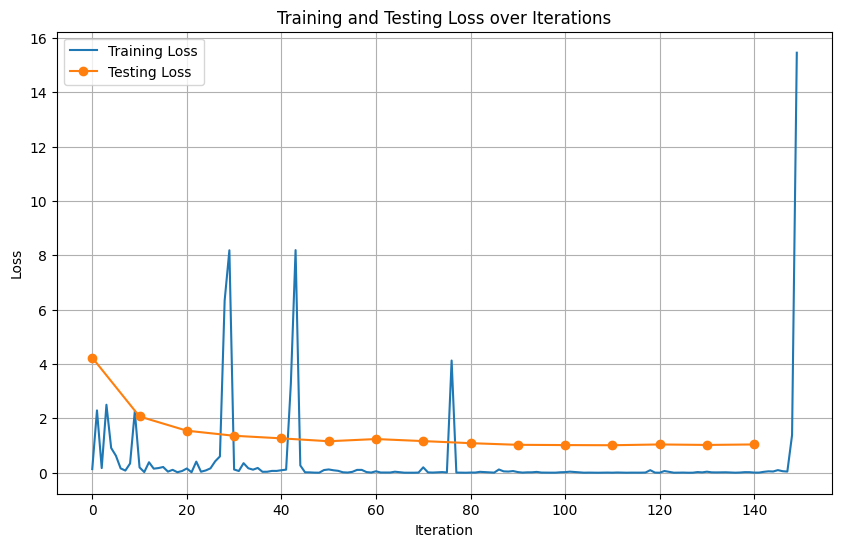

In [552]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

config = Config(len(features), 512, 8, 8, block_size)
model = LLama(config)
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=3e-5)
iters = 150
batch_size = 32
train_losses = []
test_losses = []

num_batches = len(train_prices_scaled) // batch_size

for i in range(iters):
    batch_index = i % num_batches
    
    start_idx = batch_index * batch_size
    end_idx = (batch_index + 1) * batch_size
    x_train = train_prices_scaled[start_idx:end_idx]
    x, y = x_train[:, :-1, :], x_train[:, 1:, 0]
    x, y = x.to(device), y.to(device)
    optim.zero_grad()
    
    logits, train_loss = model(x, y)
    
    train_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optim.step()
    
    train_losses.append(train_loss.item())
    
    if i % 10 == 0:
        print(i)
        with torch.no_grad():
            x_test = test_prices_scaled
            x_test, y_test = x_test[:, :-1, :], x_test[:, 1:, 0]
            x_test, y_test = x_test.to(device), y_test.to(device)
            _, test_loss = model(x_test, y_test)
            test_losses.append((i, test_loss.item()))
        print(train_loss.item(), test_loss.item())


test_loss_indices, test_loss_values = zip(*test_losses)

plt.figure(figsize=(10, 6))
plt.plot(range(iters), train_losses, label='Training Loss')
plt.plot(test_loss_indices, test_loss_values, label='Testing Loss', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Iterations')
plt.legend()
plt.grid(True)
plt.show()


In [570]:
class Market:
    def __init__(self, df, starting_cash=1000):
        self.df = df
        self.cash = starting_cash
        self.position = 0
        self.day = 0
    
    def reset(self):
        self.day = block_size
        return self.df.iloc[self.day-block_size:self.day], self.cash, self.day, self.position

    def step(self, action):
        """
        action: tuple(action, amount)
        """

        row = self.df.iloc[self.day]
        if action[0] == "sell":
            assert self.position > 0
            reward = row['close'] * self.position
            self.cash += reward
            self.position = 0

            
        elif action[0] == "buy":
            reward = row['close'] * action[1]
            print(reward, self.cash)
            assert self.cash >= reward
            self.position = action[1]
            self.cash -= reward

        self.day += 1
        return self.df.iloc[self.day-block_size:self.day], self.cash+self.position*row['close'], self.day, self.position

    def liquidate(self):
        row = self.df.iloc[self.day]
        if self.position > 0:
            reward = row['close'] * self.position
            self.cash += reward
            self.position = 0
        return self.cash

In [572]:
def rescale(scaler, value):
    value = value.cpu().detach().numpy()
    value = value.reshape(-1, 1)
    dummy_array = np.zeros((value.shape[0], len(features)))
    dummy_array[:, features.index('open')] = value[:, 0]

    predictions_original_scale = scaler.inverse_transform(dummy_array)

    predictions_original_open = predictions_original_scale[:, features.index('open')]
    return predictions_original_open


dum_model = LLama(config)
dum_model.to(device)
balances = []
cash = 1000
iters = 1000
actions = {"buy": 0, "sell": 0, None: 0}
for name, company_df in testing_companies:
    env = Market(company_df, starting_cash=cash)
    df, cash, day, position = env.reset()
    
    for i in range(len(company_df)-block_size-1):
        # scaled_features = torch.tensor(scaler.transform(df[features].values.tolist()), dtype=torch.float32).reshape(1, block_size, -1).to(device)
        # out, _ = model(scaled_features)
        # # out, _ = dum_model(scaled_features)
        # out = out[-1]
        # out = rescale(scaler, out)
        # action = (None, None)
        # if position == 0:
        #     if out > df.iloc[-1]['close']:
        #         action = ("buy", 10)
        # elif position > 0:
        #     if out < df.iloc[-1]['close']:
        #         action = ("sell", position)
        # actions[action[0]] += 1
        action = (None, None)
        if position == 0:
            action = ("buy", 10)
        df, balance, day, position = env.step(action)
        balances.append(balance)
        # break
    cash = env.liquidate()
    balances.append(cash)
    print(f"after {day-block_size} days, {name} ended with {cash}")
plt.plot(balances)
print(actions)

0
163.0 1000
164.5 837.0
162.2 672.5
165.9 510.3
168.1 344.4
169.0 176.29999999999998
166.0 7.299999999999983


AssertionError: 

In [564]:
# dum 2966.5000000000005
# my 4200.599999999999